In [1]:
import argparse
import time
import torch
from torch.utils.data import DataLoader
from torch_sparse import SparseTensor
from model import AutoLink_l3, SearchGraph_l31
import os.path as osp
from torch.autograd import Variable
from torch_geometric.datasets import Planetoid
from logger import Logger
from utils import do_edge_split, evaluate_auc, IndexLoader
from torch_geometric.utils import to_undirected, add_self_loops, negative_sampling
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
import pandas as pd

In [2]:
dataset = Planetoid('./dataset/Cora', 'Cora')

In [3]:
dataset

Cora()

The Cora dataset consists of 2708 scientific publications classified into one of seven classes. The citation network consists of 5429 links. Each publication in the dataset is described by a 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary. The dictionary consists of 1433 unique words.

In [4]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [5]:
print(f'Number of nodes: {data.num_nodes}')

Number of nodes: 2708


In [6]:
print(f'Number of edges: {data.num_edges}')
# The papers in the Cora dataset have 5429 citation connections.

Number of edges: 10556


In [7]:
print(f'Number of keywords in dictionaries (features): {data.x.shape[1]}')

Number of keywords in dictionaries (features): 1433


In [8]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}') 
print(f'Has self-loops: {data.has_self_loops()}')  
print(f'Is undirected: {data.is_undirected()}')  # each edge is counted as 2 (to and from)

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [9]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
edge_example = edge_index[:, np.where(edge_index[0]==30)[0]] # head is 30th node
edge_example

(2, 10556)


array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]], dtype=int64)

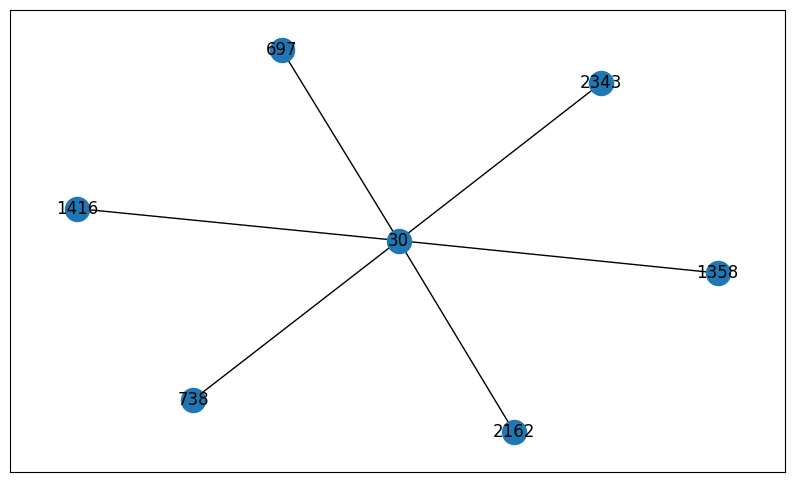

In [26]:
node_example = np.unique(edge_example.flatten())
plt.figure(figsize=(10, 6))
G = nx.Graph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0], edge_example[1])))
nx.draw_networkx(G, with_labels=True)

In [11]:
print(f'Average edges per node: {data.num_edges / data.num_nodes:.2f}')

Average edges per node: 3.90


In [30]:
# from collections import Counter

# count = []
# for k, v in Counter(degrees).items():
#     count.append((k, v))

# count.sort()
# print(count)

[(1, 485), (2, 583), (3, 553), (4, 389), (5, 281), (6, 131), (7, 82), (8, 57), (9, 25), (10, 26), (11, 14), (12, 18), (13, 5), (14, 6), (15, 6), (16, 7), (17, 8), (18, 3), (19, 5), (21, 3), (22, 1), (23, 3), (26, 1), (29, 1), (30, 2), (31, 1), (32, 2), (33, 1), (34, 1), (36, 1), (40, 1), (42, 1), (44, 1), (65, 1), (74, 1), (78, 1), (168, 1)]


Text(0, 0.5, 'node counts with x degrees')

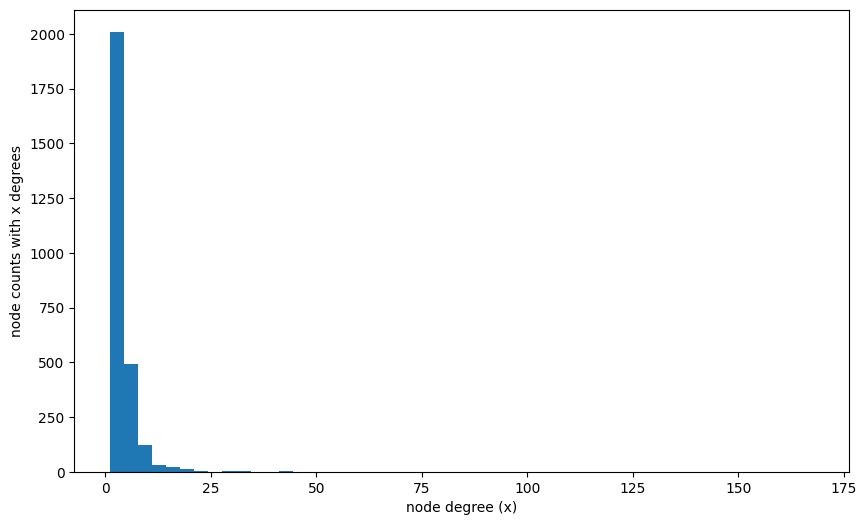

In [12]:
G = to_networkx(data, to_undirected=True)
degrees = [val for (node, val) in G.degree()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree (x)")
plt.ylabel("node counts with x degrees")

threshold 0.011821204285186553


d:\Work + Project\LilacEmpre\LilacEnv\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


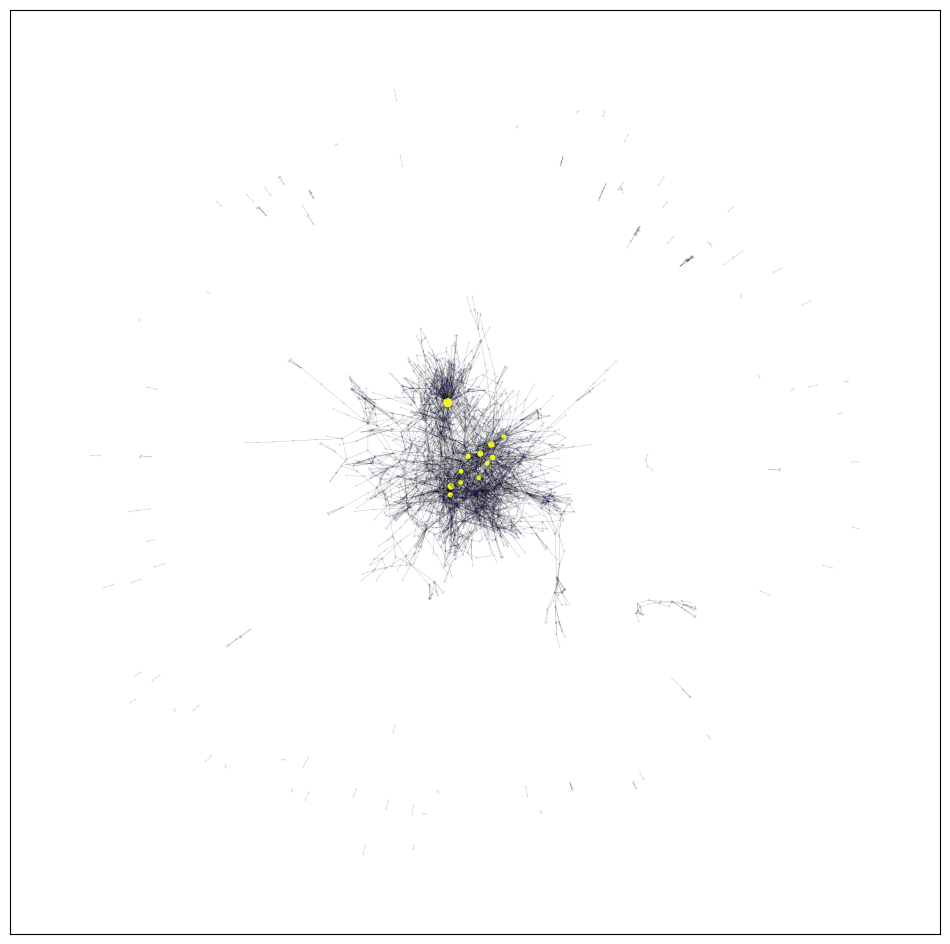

In [13]:
G = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(G, seed=42)
cent = nx.degree_centrality(G)
node_size = list(map(lambda x: x * 500, cent.values()))
cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse=True)[10] # highlight top 10 cited nodes
print("threshold", threshold)
cent_bin = np.where(cent_array >= threshold, 1, 0.1)
plt.figure(figsize=(12, 12))
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                               cmap=plt.cm.plasma,
                               node_color=cent_bin,
                               nodelist=list(cent.keys()),
                               alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.3)
plt.show()

## PS2


In [14]:
args = argparse.Namespace(
    device=0,
    use_sage='GCN',
    test_sage='GCN',
    dataset='Cora',
    use_node_embedding=False,
    use_valedges_as_input=True,
    num_layers=3,
    arch_layers=3,
    hidden_channels=32,
    hidden_channels_retrain=32,
    arch_dim=256,
    temperature=0.07,
    cat_type='multi',
    dropout=0.5,
    lin_layers=3,
    batch_size=1024,
    seed=42,
    lr=0.01,
    lr_fine=0.0001,
    learning_rate_min=0.001,
    epochs=50,
    eval_steps=1,
    runs=2,
    patience=50
)

In [15]:
model = AutoLink_l3(data.num_features, args.hidden_channels, args.num_layers, args.dropout, args.use_sage,
                        lin_layers=args.lin_layers, cat_type=args.cat_type).to('cpu')

In [16]:
state_dict = torch.load('weight/l3bl-GCN_GCN_Cora_arch-3-256-0.5_3-lin3_lr0.01-tem0.07_hidd32-32_multi_modelfine_1.pth')

In [17]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [18]:
node_example

array([  30,  697,  738, 1358, 1416, 2162, 2343], dtype=int64)

In [19]:
edge_example

array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]], dtype=int64)

In [20]:
data.x.shape # [nodes, features]

torch.Size([2708, 1433])

In [21]:
data.x

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [22]:
for i in range(data.x[0].shape[0]):
    print(int(data.x[0][i].item()), end = '')
    assert int(data.x[0][i].item()) == 1 or int(data.x[0][i].item()) == 0

0000000000000000000100000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [32]:
data.__dict__

{'_edge_attr_cls': torch_geometric.data.data.DataEdgeAttr,
 '_tensor_attr_cls': torch_geometric.data.data.DataTensorAttr,
 '_store': {'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), 'edge_index': tensor([[ 633, 1862, 2582,  ...,  598, 1473, 2706],
         [   0,    0,    0,  ..., 2707, 2707, 2707]]), 'y': tensor([3, 4, 4,  ..., 3, 3, 3]), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ...,  True,  True,  True])}}

In [23]:
result = model(data.x, data.edge_index)
result

tensor([[[ 0.2391, -0.2967, -0.2029,  ...,  0.1270,  0.8131, -0.8343],
         [ 0.4647,  0.0922,  0.2373,  ...,  0.5202,  0.7389, -0.4413],
         [ 0.1440, -0.9137,  0.0409,  ...,  0.0905,  1.0146, -0.3456]],

        [[-0.5609, -1.4906,  0.2503,  ...,  0.9902,  0.6268, -0.0701],
         [ 0.2363, -0.1727,  0.2315,  ...,  0.6556,  1.0615, -0.1119],
         [-0.2436, -0.2140,  0.5544,  ...,  1.3160,  1.3275, -0.0035]],

        [[ 0.6991, -1.2052,  0.8696,  ...,  0.2493,  0.5412, -0.8982],
         [ 0.4301,  0.1435,  0.7698,  ...,  0.3323,  0.6213, -0.6695],
         [ 0.3309,  0.0175,  0.9570,  ...,  0.3696,  1.1404, -0.6969]],

        ...,

        [[-0.3261,  0.3933, -0.0559,  ...,  0.4117,  0.5756,  0.0211],
         [-0.3784, -0.0772, -0.3038,  ...,  0.7454,  1.4130,  0.2459],
         [-0.7378,  0.2296, -0.6731,  ...,  0.0552,  0.5350, -0.2504]],

        [[ 0.5384, -0.9840,  1.0087,  ...,  0.0743,  0.9807, -0.6622],
         [ 0.7382, -0.0146,  1.0846,  ...,  0.0750,  2.

In [24]:
result.shape

torch.Size([2708, 3, 32])

In [25]:
result[0]
# This is h where u = 0 (0th node) and K = 3

tensor([[ 0.2391, -0.2967, -0.2029, -0.0534, -0.8364,  0.4747, -0.0131,  0.2188,
          0.4527, -0.0595, -0.0555,  0.2990,  0.1501,  1.1710, -0.2795,  0.6520,
          1.2427, -0.4817, -0.5711, -0.2875,  0.9625,  0.0885,  0.9035, -0.5721,
         -0.1992, -0.3226, -0.1735, -0.1048, -0.5348,  0.1270,  0.8131, -0.8343],
        [ 0.4647,  0.0922,  0.2373, -0.5442, -0.8413,  0.5879, -0.1444, -0.4439,
          0.5565, -0.4880, -0.0836, -0.2171,  0.0272,  1.3636,  0.3138, -0.0446,
          0.0701,  0.0377, -0.5012, -0.4010, -0.2554,  0.1302,  0.6840, -0.2106,
         -0.4800, -0.0997, -0.6006,  0.3639, -0.7872,  0.5202,  0.7389, -0.4413],
        [ 0.1440, -0.9137,  0.0409,  0.2906, -0.7859,  0.4197, -0.2294, -0.2792,
         -0.0851, -0.0465, -0.2535,  0.5250, -0.2440,  1.5139,  0.0174,  0.1269,
          0.5471, -0.1876, -0.9131, -0.7300,  0.6639, -0.4832,  0.3573, -0.1474,
         -0.3194, -0.2500,  0.2252,  0.8558, -0.6004,  0.0905,  1.0146, -0.3456]],
       grad_fn=<SelectBa

In [31]:
result[1]
# This is h where v = 1 (1th node) and K = 3

tensor([[-0.5609, -1.4906,  0.2503, -0.8908,  0.7908,  0.7378, -0.0864,  0.1273,
         -0.2237, -1.5999, -0.3412,  1.2791, -0.8850,  1.3836, -1.1066,  0.1308,
         -1.2674,  0.9892, -0.5165,  0.1600,  1.0668, -0.7136, -0.8867,  0.1145,
         -0.1273, -0.0362,  0.6831, -0.2222, -0.5543,  0.9902,  0.6268, -0.0701],
        [ 0.2363, -0.1727,  0.2315, -1.0751,  0.5112,  0.4856, -0.2447,  0.7390,
         -0.8612, -1.1850, -0.1588,  0.9653, -0.7177,  1.9499, -0.8981,  0.6195,
         -0.5875,  0.9189, -0.2569, -0.7037,  1.8084, -0.2946, -0.6853, -1.0094,
         -0.6083,  0.0681, -0.1894,  0.5976, -0.0688,  0.6556,  1.0615, -0.1119],
        [-0.2436, -0.2140,  0.5544, -1.7016,  0.5995,  0.3280,  0.3713,  1.2276,
         -0.7300, -1.1135, -1.2847,  1.4345, -0.6564,  0.9840, -0.8711,  0.9501,
         -1.3942,  0.3190,  0.4819, -0.1010,  1.7048, -0.9860, -1.0601, -0.7928,
         -0.7039,  0.1945,  0.2293,  0.5017, -0.2283,  1.3160,  1.3275, -0.0035]],
       grad_fn=<SelectBa

With $h_0^3$ and $h_1^3$, concatenate them -> $z_{0,1}$
$$z_{0,1} = [h_0^3, h_1^3]$$

- With the two above h representations, concatenate them and we can have $K^2$ edge representations of edge between the node 0 and node 1, $z_{u,v}$.
$$z_{0,1} = [h_0^i, h_1^j]$$
- With MLP layer and ReLU activation function, we can calculate importance scores, 
$$a_{u,v}^{i,j} = g_\theta(z_{u,v}^{i,j})$$ 
  where $a_{u,v}=[a_{u,v}^{1,1}, ..., a_{u,v}^{K,K}]$ is a subgraph related weight vector for edge $e_{u,v}$
- Use argmax to find the best $(i, j)$ corresponding to the maximum $a_{u,v}^{i,j}$

# Dissect ps2_planetoid

In [7]:
import sys
import math
from tqdm import tqdm
import random
import numpy as np
import scipy.sparse as ssp
from scipy.sparse.csgraph import shortest_path
import torch
from sklearn.metrics import roc_auc_score, average_precision_score
from torch_geometric.data import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import (negative_sampling, add_self_loops,
                                   train_test_split_edges)
import pdb

In [3]:
path = './dataset/Cora'
dataset = Planetoid(path, 'Cora')

In [4]:
dataset

Cora()

In [6]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])